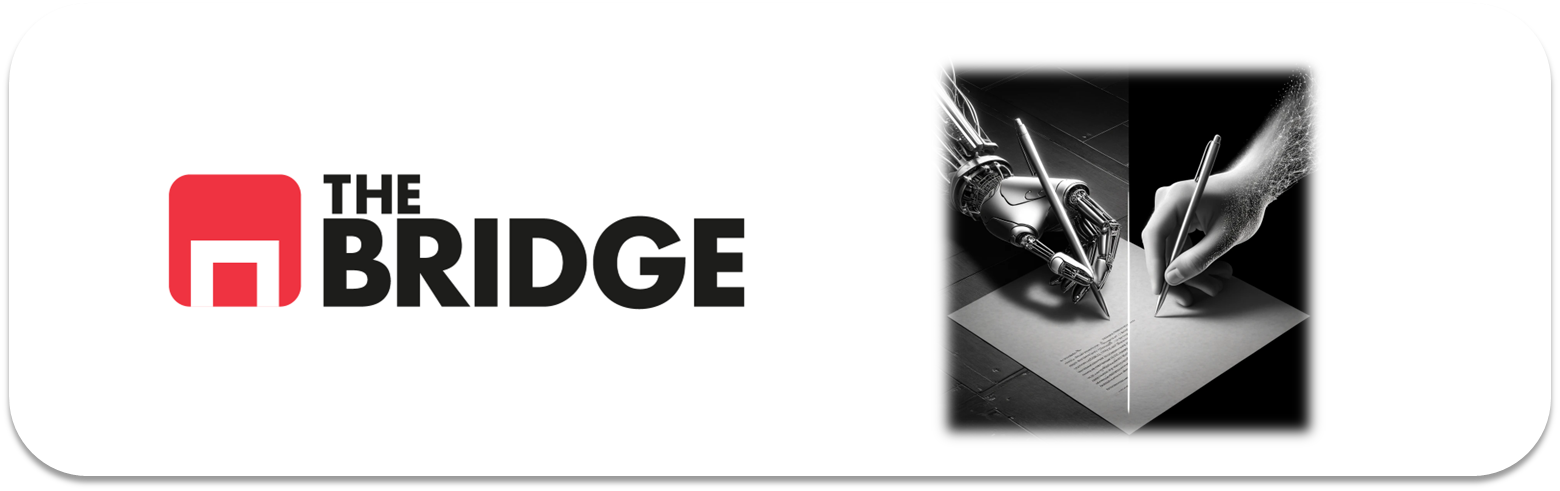

## Una (muy) breve (pero densa) introducción a la IA Generativa en Textos

*NOTA: Este notebook adapta y amplía parte del capítulo dedicado a NLP en el excelente libro [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch16.html#nlp_chapter)*

La generación de textos y más que eso el tratamiento de lenguaje natural ha dado un salto "cuántico" en los últimos años dentro del campo de la IA. Vamos a ver de una forma poco ortodoxa la evolución partiendo de las arquitecturas más complejas sobre redes recurrentes hasta terminar en los instruct LLM (la base de la IA multimodal generativa actual). Será un viaje denso y breve, pero espero que despierte el interés en ti para ampliar más con el material extra que se proporciona en la plataforma y en algunos enlaces de este notebook.

*Antes de empezar, este notebook "no" se recomienda si no se ejecuta en un entorno con GPU disponible. Si no es el caso -> Colab:*



<table align="left">
  <td>
    <a href="https://colab.research.google.com/github.com/Jaimegrp/Practicando/blob/main/Texto/Generativa_Texto_De_RRN_a_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from pathlib import Path
from time import time, sleep


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Usando RNNs: Una estrutucar Encoder-Decoder para traducir de inglés a español

El primer gran avance por encima de la vectorización y las técnicas iniciales de resumen (summarization), traducción (translation), preguntas y respuestas (Q&A), es el empleo de redes recurrentes en el tratamiento de textos. Veamos un ejemplo.

El objetivo del siguiente ejemplo es doble:  
1. Mostrar como las redes recurrentes pueden configurarse para tratar un problema de traducción donde a una secuencia de entrada de longitud variable le corresponderá una secuencia de longitud variable y además no necesariamente coincidente, en dicha longitud, con la de entrada. Este problema se aplica a la traducción de inglés a español pero es un esquema que se puede emplear en cualquier tipo de cambio de representación entre secuencias (yes, para pasar de una secuencia a una imagen y viceversa).  

2. Introducir de forma progresiva el concepto de Atention (atención) para mejorar el modelo anterior y sobre este la arquitectura conocida como Transformers, que nos permitirá hablar de GPT, BERT y los LLN (Large Language Models, no Master of Laws, ojo) en general.

### El dataset de entrenamiento

Utilizaremos un datset que empareja palabras y frases en inglés con sus traducciones al español de Tensorflow

In [26]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text(encoding = "utf-8")

Observamos su contenido (siempre hay que mirar la mercancía antes de ponerse a cocinar)

In [27]:
print(text[:100])

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fueg


Lo transformamos para que sea una relación de secuencia a secuencia (dada una secuencia tenemos su target)

In [28]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [29]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


## ENCODER-DECODER

En la sesión de redes recurrentes ya vimos la estructura básica y citamos algún uso de la misma  

<img src="./img/encoder_decoder.jpg" alt="Diagram of encoder_decoder" width="400" />

Y, ¿por qué esta arquitectura? Porque antes de que se propusiese no había forma de entrenar modelos que admitiesen secuencias de longitud variable con target otra secuencia de longitud variable (y por tanto pudiendo ser esa longitud diferente a la primera)

El encoder ahora se encarga de convertir cualquier secuencia que haya a la entrada en un vector de longitud fija y el decoder convertira este vector en una secuencia de salida de longitud variable.  

De hecho al encoder le vamos a dar de comer secuencias de longitud fija pero lo suficientemente larga como para que entren todas, y aplicaremos el truco del padding para completar y el de la máscara para que no le afecte a las secuencias cortas.

Este es el modelo que vamos a construir (sin "desenrrollar")

<img src="./img/encoder_decoder_to_train.jpg" alt="Diagram of encoder_decoder" width="600" />

Mejor si lo desenrrollamos:

<img src="./img/encoder_decoder_unrolled.jpg" alt="Diagram of encoder_decoder" width="600" />

Veamos como funcionaría (en entrenamiento): 
1. Al enconder le damos la secuencia [I, like, soccer], y no le va a pasar nada todavía al encoder... 
2. Hace el embedding, supongamos que de 2 dimensiones, [ (0.212,-3.32), (1.34, 0.344), (6.665,-4.443)]
3. Procesa la secuencia uno a uno y va transmitiendose el hidden_state ( y la cell_state, es una LSTM) en cada elemento de la secuencia:
    Procesa: e0: [(0.212,-3.32),(0,0,...0),(0,0.....)]
    Procesa: e1: [(1.34,0.344), h([(0.212,-3.32),(0,0,...0),(0,0.....)]),c((0.212,-3.32),(0,0,...0),(0,0.....))] (recordad que las LSTM tienen dos estados ocultos h y c el primero en teoría para la memoria a corto y el segundo para la memoria a largo)
    Procesa: e2 [(6.665, -4.443), h(e1), c(1)]
4. Ahora sí devuelve [salida(e2),h(e2),c(2)] y esto es parte de lo que entra en el Decoder
5. El decoder a la vez ha hecho el embedding de su entrada [emb("<sos>"),emb("Me"),emb("gusta"),emb("el"),emb("fútbol")] 
5. Lo primero que procesa el decoder es d1: [h(e2),c(e2),emb("<sos>")] y la capa de salida predice (en el caso de la figura) "me"  
6. Luego procesa d2: [emb("Me"),h(d1),c(d1)] y la capa de salida predice (en este caso): "encanta"
7. procesa d3: [emb("gusta"),h(d2),c(d2)] y la capa de salida predice: "el" (Importante, le entre el embedding de la palabra que tendría que haber predicho antes ("gusta") no la que realmente predijo "encanta")
8. procesa d4: [emb("el"),h(d3),c(d3)] y la capa de salida predice: "fútbol"
9. procesa d5: [emb("fútbol"),h(d4),d(4)] y la capa de salida predice: "<eos>" (end of sequence) (podría haber hecho la predicción de otra palabra y hubiera acabado igual pero se contabilizaría como un error para el optimizador, etc, etc)
10. Se acaba la secuencia de entrada para el decoder

A destacar:
- El encoder sólo le pasar el hidden_stat (h y c) del final de la secuencia de entrada al decoder
- El decoder trabaja sobre el target completo desplazado una vez (esto nos sirve para construir el vec2seq)



### Construcción del modelo

Ok, ahora que todo ha quedado clarito como el barro, vamos a construir el modelo.  
Primero las capas de embeddings como ya hemos visto primero nuestros vectorizadores para convertir cada sentencia en secuencia de índices y después la capa de embedding para que aprenda cual es la mejor reprensentación de cada índice/palabra

In [37]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es]) # Importante le añadimos el comienzo de secuencia y el final para que sepa donde empieza y para que aprenda cuando se acaba

In [38]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [39]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

Construímos los datasets de entrenamiento y validación, teniendo encuenta que encoder y decoder reciben entradas ligeramente diferentes y que el targert debe contener el endofseq (que es un token que debe predecir el modelo, es decir debe predecir cuando acaba la frase)

In [40]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

Y ahora sí, comenzamos con la definición (funcional del modelo)

In [63]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [64]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [65]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings) # IMPORTANTE obtenemos los estados de salida del encoder que es lo que....

In [66]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state) # ... realmente vamos a pasar al decoder para el primer token (<sos>) de la secuencia de guía (que en el entrenamiento es la de target desplazada)

In [67]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax") # La salida es una softmax con tantas neuronas como términos en el vocabulario, es decir estamos prediciendo el índice de cada palabra de la respuesta. Luego tendremos que decodificarlo para obtener la palabra real
Y_proba = output_layer(decoder_outputs)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [68]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
 597/3125 [====>.........................] - ETA: 7:07:02 - loss: 3.9503 - accuracy: 0.3110

Una vez entrenado el modelo, la traducción tiene un poco de miga.   

El decoder espera que le pasemos una secuencia guía (el teacher), que es la función que hacía la secuencia target desplazada uno en el entrenamiento.  

Lo que vamos a hacer es ir prediciendo palabra a palabra introduciendo como guía la última predicción hasta llegar a que el modelo devuelva el carácter de fin de secuencia y en ese momento devolvemos la "traducción"

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

Probemos con algo sencillo

In [55]:
translate("I like soccer")

NameError: name 'translate' is not defined

Bien!!! Pero qué ocurre si le pedimos algo más largo

In [ ]:
translate("I like soccer and also going to the beach")

'me gusta el fútbol y a veces mismo al bus'

Vamos a ver mejoras que además nos vayan adelantando conceptos para llegar a los LLN

## Bidirectional RNNs

Una red recurrente bidireccional es la que lee la secuencia tanto de izquierda a derecha como de derecha a izquierda y procesa ambas secuencias en conjunto. Ojo: la secuencia de entrada.

En general es como tener una capa que mira en un sentido y otra en el otro y concatenar luego sus salidas

<img src="./img/bidirectionalrnn.PNG" alt="Bidirectional RNN" width="700" />

¿Por qué y para qué? Porque, por ejemplo, hay frases que para traducirlas necesitas ver que viene después, como en el caso de los adjetivos en inglés que anteceden al nombre y de los sinónimos en un idioma que no coinciden necesariamente con los sinónimos en otro: the left arm, the left party, they left the restaurant...


Para crear un capa recurrente bidireccional, se hace lo siguiente (encapsular una recurrente en una más genérica denominada Bidirectional)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

En el caso del decoder no podemos hacer lo mismo porque en el target mirar al futuro sí es hacer trampa (recordemos que hasta ahora le pasamos la palabra que correspondería a la palabra esperada anterior, o sea no hacemos trampa), y por tanto no serviría para predecir algo que no hubiera visto (de hecho no podríamos construir una entrada para predecir de forma correcta)

Pero, la recurrente bidireccional produce el doble de estados ocultos. Como se trata de una lstm tendremos dos hidden_state y dos cell_state, aunque el decoder sólo espera dos (porque es otra LSTM, pregunta para pensar sobre ello (¿puedo poner redes recurrentes diferentes en el encoder y el decoder?))

Lo que hacemos es concatenarlos.

In [59]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [ ]:
# extra code — completes the model and trains it
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 574s 181ms/step - loss: 0.3075 - accuracy: 0.5393 - val_loss: 0.2192 - val_accuracy: 0.6319
Epoch 2/10
3125/3125 [==============================] - 564s 180ms/step - loss: 0.1916 - accuracy: 0.6689 - val_loss: 0.1880 - val_accuracy: 0.6731
Epoch 3/10
3125/3125 [==============================] - 566s 181ms/step - loss: 0.1602 - accuracy: 0.7119 - val_loss: 0.1751 - val_accuracy: 0.6916
Epoch 4/10
3125/3125 [==============================] - 566s 181ms/step - loss: 0.1395 - accuracy: 0.7415 - val_loss: 0.1715 - val_accuracy: 0.6979
Epoch 5/10
3125/3125 [==============================] - 566s 181ms/step - loss: 0.1227 - accuracy: 0.7666 - val_loss: 0.1707 - val_accuracy: 0.7025
Epoch 6/10
3125/3125 [==============================] - 567s 181ms/step - loss: 0.1085 - accuracy: 0.7887 - val_loss: 0.1730 - val_accuracy: 0.6995
Epoch 7/10
3125/3125 [==============================] - 571s 183ms/step - loss: 0.0961 - accuracy: 0.8089 - val_

In [ ]:
translate("I like soccer")

'me gusta el fútbol'

Otra posible optimización es lo que se denomina Beam Search. Se deja a modo de ejercicio para entenderlo y una referencia explicativa:
https://towardsdatascience.com/an-intuitive-explanation-of-beam-search-9b1d744e7a0f

## Beam Search

This is a very basic implementation of beam search. I tried to make it readable and understandable, but it's definitely not optimized for speed! The function first uses the model to find the top _k_ words to start the translations (where _k_ is the beam width). For each of the top _k_ translations, it evaluates the conditional probabilities of all possible words it could add to that translation. These extended translations and their probabilities are added to the list of candidates. Once we've gone through all top _k_ translations and all words that could complete them, we keep only the top _k_ candidates with the highest probability, and we iterate over and over until they all finish with an EOS token. The top translation is then returned (after removing its EOS token).

* Note: If p(S) is the probability of sentence S, and p(W|S) is the conditional probability of the word W given that the translation starts with S, then the probability of the sentence S' = concat(S, W) is p(S') = p(S) * p(W|S). As we add more words, the probability gets smaller and smaller. To avoid the risk of it getting too small, which could cause floating point precision errors, the function keeps track of log probabilities instead of probabilities: recall that log(a\*b) = log(a) + log(b), therefore log(p(S')) = log(p(S)) + log(p(W|S)).

In [ ]:
# extra code – a basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # list of best (log_proba, translation)
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]
    
    # extra code – displays the top first words in verbose mode
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [ ]:
# extra code – shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

'me [UNK] los gatos y los gatos'

In [ ]:
# extra code – shows how beam search can help
beam_search(sentence_en, beam_width=3, verbose=True)

Top first words: [(-0.012974381, 'me'), (-4.592527, '[UNK]'), (-6.314033, 'yo')]
Top translations so far: [(-0.4831518, 'me [UNK]'), (-1.4920667, 'me encanta'), (-1.986235, 'me gustan')]
Top translations so far: [(-0.6793061, 'me [UNK] los'), (-1.9889652, 'me gustan los'), (-2.0470557, 'me encanta los')]
Top translations so far: [(-0.7609749, 'me [UNK] los gatos'), (-2.0677316, 'me gustan los gatos'), (-2.26029, 'me encanta los gatos')]
Top translations so far: [(-0.76985043, 'me [UNK] los gatos y'), (-2.0701222, 'me gustan los gatos y'), (-2.2649746, 'me encanta los gatos y')]
Top translations so far: [(-0.81283045, 'me [UNK] los gatos y los'), (-2.118244, 'me gustan los gatos y los'), (-2.96167, 'me encanta los gatos y los')]
Top translations so far: [(-1.2259341, 'me [UNK] los gatos y los gatos'), (-1.9556838, 'me [UNK] los gatos y los perros'), (-2.7524388, 'me gustan los gatos y los perros')]
Top translations so far: [(-1.2261332, 'me [UNK] los gatos y los gatos endofseq'), (-1.95

'me [UNK] los gatos y los gatos'

The correct translation is in the top 3 sentences found by beam search, but it's not the first. Since we're using a small vocabulary, the \[UNK] token is quite frequent, so you may want to penalize it (e.g., divide its probability by 2 in the beam search function): this will discourage beam search from using it too much.

# Attention Mechanisms

Como mejora a este tipo de arquitecturas, en 2014 (Dzmitry Bahdanau y colegas, et al. que se dice) introdujeron una mejora sustancial a la arquitectura de Encoder-Decoders. 

La idea detrás del mecanismo es pasarle al decoder más información de la secuencia de entrada y no sólo los estados ocultos producidos por el último elemento (el primero y el úlitmo en el caso de bidireccionales). ¿Qué información? Pues algo así como la palabra que más le aporte en cada momento. Por ejemplo que cuando al decoder le toque producir fútbol en la traducción de I like soccer, reciba "soccer" (en concreto la salida del enconder a la palabra "soccer").  

Supongamos que estamos traduciendo frases como:

I like soccer  
I like Rain Man  
you like The Bridge  
we like Marta  
  
Para los dos primeras el decoder iría traduciendo:
(Me) gusta ... y la idea es que las entradas "soccer", "Rain" + "Man", "The" + "Bridge", "Marta" aporten más en ese instante...  

Entonces al decoder tendré que pasarle todas las palabras de la frase (en concreto la salida de cada una de estas del encoder) y que exista un mecanismo que le diga en función de lo que lleva cuál de las entradas debe considerar más (aquí nos fijamos en la siguiente, pero para traducir "Me" es mejor que se fije en la primera, el pronombre, para traducir "gusta", igual)  

Lo interesante no es considerar solo una palabra de entrada, sino una combinación pesada de estas (una combinación lineal -> "The" + "Bridge")

Es decir, volviendo a nuestras entradas del decoder:

* Antes d1: [h(e2),c(2),emb("<start_of_sequence>")], ahora da1 (la a es de attention): [h(e2),c(e2), (coef1 * e1 + coef2 * e2 + coef3 * e3)] y probablemente todos los coef se aproximarían a cero
* Antes d2: [emb("Me"),h(d1),c(d1)], ahora da2: [emb("Me"),h(d1),c(d1), (coef21 * e1 + coef22 * e2 + coef23 * e3)] y probablemente coef21 >> coef22 y coef23
* Antes d3: [emb("gusta"),h(d2),c(d2)], ahora da3: [emb("gusta"),h(d1),c(d1), (coef31 * e1 + coef32 * e2 + coef33 * e3) ] y coef31 y coef32 serán altos y coef33 bajo o nulo


__¿Y cómo le digo en cuál debe fijarse más? Pues como en los embeddings... que lo aprenda :-) (o sea tendré una Attention Layer)__


Muy bien, y cómo se hace ese "que lo aprenda": Dos mecanismos de Atencion (aditiva y multiplicativa), pero el multiplicativo ha superado al aditivo y de hecho la Attention Layer de keras hace Attention multiplicativa y además al final la predicción se hace a partir de la salida de la capa de atención. 

Gráficamente:

<img src="./img/encoder_decoder_with_attention.jpg" alt="Encoder_Decoder with Attention" width="700" />


Intuitivamente al poner la capa de atención al final está configurando toda la red (toda incluidos los embeddings) para que "memorice" la relación estadística entre las posiciones de salida y las de entrada en diferentes situaciones. Y luego ya nosotros a eso le llamamos atención, porque es verdad que cuando llega el momento de "Me gusta el...", ha memorizado que las posiciones que deben aportar más es donde haya salidas que generalmente pertenecen a nombres. (pero él ni sabe que son nombres, ni que está traduciendo ni nada,...)


El siguiente paso sería aumentar la memoria y olvidarse de las recurrencias (y del problema de traducir) :-)... los Transformers, pero antes... prestémosle Atención al traductor con traducción

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)) # Ahora necesitamos todas las salidas del Encoder por eso return_sequences = True

In [ ]:
# extra code – this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

And finally, let's add the `Attention` layer and the output layer:

In [ ]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 597s 189ms/step - loss: 0.3074 - accuracy: 0.5469 - val_loss: 0.2106 - val_accuracy: 0.6487
Epoch 2/10
3125/3125 [==============================] - 585s 187ms/step - loss: 0.1902 - accuracy: 0.6789 - val_loss: 0.1865 - val_accuracy: 0.6830
Epoch 3/10
3125/3125 [==============================] - 585s 187ms/step - loss: 0.1659 - accuracy: 0.7123 - val_loss: 0.1759 - val_accuracy: 0.7005
Epoch 4/10
3125/3125 [==============================] - 584s 187ms/step - loss: 0.1493 - accuracy: 0.7359 - val_loss: 0.1728 - val_accuracy: 0.7060
Epoch 5/10
3125/3125 [==============================] - 582s 186ms/step - loss: 0.1358 - accuracy: 0.7548 - val_loss: 0.1724 - val_accuracy: 0.7084
Epoch 6/10
3125/3125 [==============================] - 583s 186ms/step - loss: 0.1245 - accuracy: 0.7712 - val_loss: 0.1738 - val_accuracy: 0.7103
Epoch 7/10
3125/3125 [==============================] - 582s 186ms/step - loss: 0.1148 - accuracy: 0.7863 - val_

In [ ]:
translate("I like soccer and also going to the beach")

'me gusta el fútbol y también ir a la playa'

In [ ]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

Top first words: [(-0.26210824, 'me'), (-2.553061, 'prefiero'), (-3.2005944, 'yo')]
Top translations so far: [(-0.32478744, 'me gusta'), (-3.0608056, 'prefiero el'), (-3.1685317, 'me gustan')]
Top translations so far: [(-0.7464272, 'me gusta el'), (-2.4712462, 'me gusta fútbol'), (-2.9149299, 'me gusta al')]
Top translations so far: [(-1.0369574, 'me gusta el fútbol'), (-2.3301778, 'me gusta el el'), (-2.9658434, 'me gusta fútbol y')]
Top translations so far: [(-1.0404125, 'me gusta el fútbol y'), (-2.5983238, 'me gusta el el fútbol'), (-2.9736564, 'me gusta fútbol y también')]
Top translations so far: [(-1.0520902, 'me gusta el fútbol y también'), (-2.6003318, 'me gusta el el fútbol y'), (-3.128903, 'me gusta fútbol y también me')]
Top translations so far: [(-1.9568634, 'me gusta el fútbol y también ir'), (-2.6169589, 'me gusta el el fútbol y también'), (-2.6949644, 'me gusta el fútbol y también fuera')]
Top translations so far: [(-1.9676423, 'me gusta el fútbol y también ir a'), (-2.

'me gusta el fútbol y también ir a la playa'

## Attention Is All You Need: The Transformer Architecture


Y en 2017, alguien de una empresa..., publicó un paper en el que se presentaba en sociedad una arquitectura que sólo necesitaba de mecanismos de Atenttion y capas Densas para hacer NMT como el mejor.

OJO, esta sección es a título ilustrativo... Pero molón

<img src="./img/transformers.webp" alt="Encoder_Decoder with Attention" width="700" />



Antes de asustarse, lo que realmente hace esta arquitectura es ser las superconvolucional con memoria de las secuencias de texto... Vamos por partes:

__La parte del encoder__ al incluir el mecanismo de atención (y ese positional encoding) lo que está haciendo es aprender las relaciones posicionales de las palabras del "lenguaje" de entrada (sí está memorizando ycaracterizando las relaciones entre todas las palabras y sus posiciones de entrada), está haciendo un embedding de la información posicional. Luego concatena la información posicional con la de entrada y aprende a relacionarla lo mejor posible para esa secuencia. En tiempo de inferencia diríamos que para cada secuencia está analizandola sintácticamente, gramaticalmente, etc, etc y luego la devuelve... Pero nunca le hemos pasado información ni sintáctica, ni gramatical, ni nada.

__La parte del decoder__ primero hace lo mismo que el encoder pero con el "lenguaje" de destino, se aprende y caracteriza todas las relaciones posicionales de las sentencias de ese "lenguaje". Combina ese embedding por secuencia con la secuencia de destino y se lo pasa a la siguiente capa de atención que ahora memoriza y caracteriza todas las relaciones posicionales entre las sentencias procesadas y enriquecidas del lenguaje origen y las sentencias procesadas y enriquecidas del lenguaje de origen. Y luego el feedfoward es el que realmente mezcla todo (mezclará toda la información de la secuencia, vease que se va transmitiendo, las posiciones y las posiciones con el lenguaje origen). 

Para aumentar la memoria y dar más relaciones lo que hacemos es que la capa de atención en realidad son muchas capas de atención en paralelo y acumular modulos de atención (como acumulábamos capas convolucionales en una red convolucional)

A título ilustrativo un __capa multihead de atención__:

<img src="./img/multihead_attention.png" alt="Multihead Attention Layer" width="700" />

Las capas linear son capas densas sin función de activación, tienen pesos entrenables -> Memoria (en estos pesos está la memoria de las características posicionales)
Y las capas head fuerzan que las linear (tantas como cabezas*3) aprendan un número de relaciones "poscionales" que dependen del número de cabezas (si quiero que apredan más relaciones posicionales -> Más cabezas)



Y para terminar hay N modulos (en el paper de 2017, 6 por Encoder y 6 por Decoder) apilados, ¿por qué? Aquí una idea intuitiva es la misma que en las convolucionales, para que pueda memorizar relaciones posicionales más complicadas (y tener más memoria entrenable).

## Large Language Models (Pretrained Transformers)

Y en 2018, llegaron las arquitecturas que apilaban multihead attention layers pero ya olvidándose de decoders y encoders... Una sola columna con muchos módulos... pero con la magia de estar pre-entrenadas para una tarea (generalmente adivina cuál es la siguiente palabra de la sentencia (GPT) o de cada sentencia te voy a ocultar 2 palabras, adivina cuales son (BERT)). 

En esencia, están memorizando todas las relaciones que existen entre las palabras de un lenguaje... Por eso cada vez se hacen más grandes (para memorizar más) y tienen más parámetros... y necesitan más que les des de comer (si quieres tenerlo todo representado)... (Imagina que le pudieras dar para entrenar a un red convolucional todas las imágenes posibles que existen)

<img src="./img/gpt2_vs_BERT.jpg" alt="Multihead Attention Layer" width="800" />

Luego estos modelos preentrenados se adaptan (fine-tunning), o sea se hace transfer learning, a otros tipos de problemas (clasificación, sentiment analysis, question and answers, y ahora chats, texto generativo).





INSTRUCT LLM o los modernos "ChatGPT"

Como funcioina la slide y explicarlo (no me da la cabeza para más)

Juguemos un poco:

El truco de hacerles cambiar de orden algunas palabras, escribirlas sin la tercera letra, reordenando frases y ver qué sale.

Tour: 

Closed or semi-closed
- ChatGPT
- Gemini
- Cloude-3
- Mistral (Semi)

Open:
- Llama-2, variante de andar por casa
- Stable AI
- Toda la panoplia necesidades

Dos ejemplos:
- Usar un Mistral cuantizado y resumiendo un artículo y con un listado de docs
- Usar las APIS y un listado de docs. (Uso programático de las APIs) [Un notebook final]

Terminar hablando de LangChain y RAG, enviarles a los cursos. Hablarles de los docs Surveys (usarlos como ejemplos)
Enseñarles los cursos.



A mano:
Asistente virtual para una clase -> Coger la transcripcion y hacerle preguntas (para la API de flask sería un ejercicio cojonudo con doble API)
Coger un listado de pdfs y que haga un resumen de estos, convirtiendo el pdf primero a texto (adaptar de lo que tengo para soluciona mi deuda, el supercool sería WebScrapping de artículos de periódico, y que haga el resumen de los mismos, usando chatgpt 3.5)

Mirarme si tienen API el resto y hablar de ellas.

Con LangChain:??
Un ejemplo sencillo (el RAG del curso), lo anterior con RAG, quizás hablarles bien de los cursos de Andrew Ng, mientras TheBridge prepara los suyos :-)


Further Reading:
LangChain
RAG

# PROGRAMANDO UN TRANSFORMER

En las siguientes celdas se muestra como construir un transformer para nuestro traductor... para el que quiera jugar (extraido del Hands-On...)

### Positional encodings

In [ ]:
max_length = 50  # max length in the whole training set
embed_size = 128
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

Alternatively, we can use fixed, non-trainable positional encodings:

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [ ]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

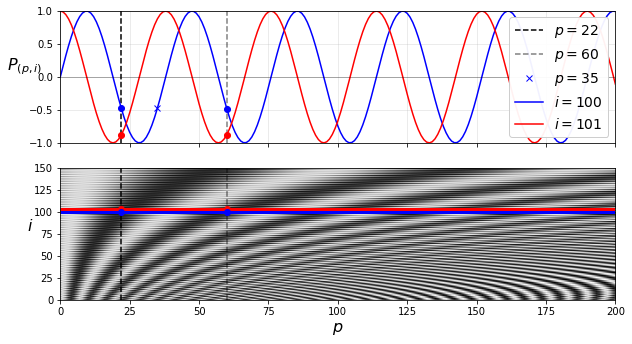

In [ ]:
# extra code – this cells generates and saves Figure 16–9
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

### Multi-Head Attention

In [ ]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

**Warning**: the following cell will take a while to run (possibly 2 or 3 hours if you are not using a GPU).

In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 828s 263ms/step - loss: 0.2982 - accuracy: 0.5545 - val_loss: 0.2105 - val_accuracy: 0.6476
Epoch 2/10
3125/3125 [==============================] - 820s 262ms/step - loss: 0.2006 - accuracy: 0.6601 - val_loss: 0.1876 - val_accuracy: 0.6802
Epoch 3/10
3125/3125 [==============================] - 820s 263ms/step - loss: 0.1842 - accuracy: 0.6816 - val_loss: 0.1766 - val_accuracy: 0.6975
Epoch 4/10
3125/3125 [==============================] - 820s 262ms/step - loss: 0.1748 - accuracy: 0.6942 - val_loss: 0.1704 - val_accuracy: 0.7055
Epoch 5/10
3125/3125 [==============================] - 820s 262ms/step - loss: 0.1683 - accuracy: 0.7021 - val_loss: 0.1657 - val_accuracy: 0.7102
Epoch 6/10
3125/3125 [==============================] - 821s 263ms/step - loss: 0.1628 - accuracy: 0.7096 - val_loss: 0.1628 - val_accuracy: 0.7130
Epoch 7/10
3125/3125 [==============================] - 826s 264ms/step - loss: 0.1588 - accuracy: 0.7154 - val_

In [ ]:
translate("I like soccer and also going to the beach")

'me gusta el fútbol y yo también voy a la playa'

In [25]:
import tensorflow as tf

X = tf.range(10)
print(X)
X_2 = tf.round(tf.random.uniform(shape= (5,4))*100,2)
print(X_2)

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)
tf.Tensor(
[[  4.  38.  40.  36.]
 [ 63.  40.  12.  36.]
 [ 84.  67.  58.  63.]
 [ 42.  92.   1.  78.]
 [ 40. 100.  39.  27.]], shape=(5, 4), dtype=float32)


In [26]:
prueba = tf.data.Dataset.from_tensor_slices(X_2)
list(prueba)

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 4., 38., 40., 36.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([63., 40., 12., 36.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([84., 67., 58., 63.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([42., 92.,  1., 78.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 40., 100.,  39.,  27.], dtype=float32)>]

In [10]:
X_nested = {"a": ([1,2,3],["a","b","c"]), "b": (["Hola","adios","ok"],[1.1,2.2,-4])}

In [15]:
for elemento in tf.data.Dataset.from_tensor_slices(X_nested):
    print(elemento["a"])

(<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=string, numpy=b'a'>)
(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=string, numpy=b'b'>)
(<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=string, numpy=b'c'>)


In [16]:
prueba

<_TensorSliceDataset element_spec=TensorSpec(shape=(4,), dtype=tf.float32, name=None)>

In [27]:
prueba.repeat(3)

<_RepeatDataset element_spec=TensorSpec(shape=(4,), dtype=tf.float32, name=None)>

In [31]:
for i in prueba.repeat(3).batch(3, drop_remainder= True):
    print(i)
    print(type(i))

tf.Tensor(
[[ 4. 38. 40. 36.]
 [63. 40. 12. 36.]
 [84. 67. 58. 63.]], shape=(3, 4), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 42.  92.   1.  78.]
 [ 40. 100.  39.  27.]
 [  4.  38.  40.  36.]], shape=(3, 4), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[63. 40. 12. 36.]
 [84. 67. 58. 63.]
 [42. 92.  1. 78.]], shape=(3, 4), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 40. 100.  39.  27.]
 [  4.  38.  40.  36.]
 [ 63.  40.  12.  36.]], shape=(3, 4), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 84.  67.  58.  63.]
 [ 42.  92.   1.  78.]
 [ 40. 100.  39.  27.]], shape=(3, 4), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [32]:
prueba.map(lambda x: x+1)

<_MapDataset element_spec=TensorSpec(shape=(4,), dtype=tf.float32, name=None)>

In [33]:
for i,dato in enumerate(prueba.map(lambda x: x+1)):
    print(dato)
    print(i)
    if i>3:
        break

tf.Tensor([ 5. 39. 41. 37.], shape=(4,), dtype=float32)
0
tf.Tensor([64. 41. 13. 37.], shape=(4,), dtype=float32)
1
tf.Tensor([85. 68. 59. 64.], shape=(4,), dtype=float32)
2
tf.Tensor([43. 93.  2. 79.], shape=(4,), dtype=float32)
3
tf.Tensor([ 41. 101.  40.  28.], shape=(4,), dtype=float32)
4


In [43]:
for i,dato in enumerate(prueba.map(lambda x: x+1)):
    print(dato)
    print(tf.reduce_sum(dato, axis = 0))
    print(i)
    if i>3:
        break

tf.Tensor([ 5. 39. 41. 37.], shape=(4,), dtype=float32)
tf.Tensor(122.0, shape=(), dtype=float32)
0
tf.Tensor([64. 41. 13. 37.], shape=(4,), dtype=float32)
tf.Tensor(155.0, shape=(), dtype=float32)
1
tf.Tensor([85. 68. 59. 64.], shape=(4,), dtype=float32)
tf.Tensor(276.0, shape=(), dtype=float32)
2
tf.Tensor([43. 93.  2. 79.], shape=(4,), dtype=float32)
tf.Tensor(217.0, shape=(), dtype=float32)
3
tf.Tensor([ 41. 101.  40.  28.], shape=(4,), dtype=float32)
tf.Tensor(210.0, shape=(), dtype=float32)
4
